In [16]:
#import necessary packages
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_classif, chi2, f_regression

In [20]:
player_ratings_19 = pd.read_csv('Data/2019-20/Players/player_ratings_19_a_09.csv')
features_19 = pd.read_csv('Data/2019-20/Fixtures/PL19_20_features.csv')
player_ratings_20 = pd.read_csv('Data/2020-21/Players/player_ratings_a_09.csv')
features_20 = pd.read_csv('Data/2020-21/Fixtures/PL20_21_features.csv')
player_ratings_21 = pd.read_csv('Data/2021-22/Players/player_ratings_21_a_09.csv')
features_21 = pd.read_csv('Data/2021-22/Fixtures/PL21_22_features.csv')
player_ratings_20.replace(['Brighton & Hove Albion','Manchester United', 'Newcastle United', 'Sheffield United', 'Tottenham Hotspur', 'West Bromwich Albion', 'West Ham United','Wolverhampton Wanderers'], ['Brighton', 'Manchester Utd','Newcastle Utd', 'Sheffield Utd', 'Tottenham','West Brom' ,'West Ham', 'Wolves'], inplace=True)
player_ratings_20['game_home_ID'] = player_ratings_20['HomeTeam'] + player_ratings_20['Date']
player_ratings_20['game_away_ID'] = player_ratings_20['AwayTeam'] + player_ratings_20['Date']
player_ratings_20

,Unnamed: 0,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,game_home_ID,game_away_ID,...,rating_a_gk,rating_a_df,rating_a_mf,rating_a_att,rating_a_bench,influence_a,creativity_a,threat_a,bps_a,selected_a
0,0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,Fulham2020-09-12,Arsenal2020-09-12,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,1,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,Crystal Palace2020-09-12,Southampton2020-09-12,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2,2,2020-09-12,17:30,Liverpool,Leeds United,4,3,H,Liverpool2020-09-12,Leeds United2020-09-12,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
3,3,2020-09-12,20:00,West Ham,Newcastle Utd,0,2,A,West Ham2020-09-12,Newcastle Utd2020-09-12,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
4,4,2020-09-13,14:00,West Brom,Leicester City,0,3,A,West Brom2020-09-13,Leicester City2020-09-13,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,375,2021-05-23,16:00,Liverpool,Crystal Palace,2,0,H,Liverpool2021-05-23,Crystal Palace2021-05-23,...,18.095864,77.508335,34.222302,114.179672,23.624494,141.292815,147.381546,121.639973,114.763385,2.700597e+06
376,376,2021-05-23,16:00,Manchester City,Everton,5,0,H,Manchester City2021-05-23,Everton2021-05-23,...,54.939201,99.089373,99.931465,83.451864,18.141813,214.701344,167.231180,133.112182,201.690987,6.039664e+06
377,377,2021-05-23,16:00,Sheffield Utd,Burnley,1,0,H,Sheffield Utd2021-05-23,Burnley2021-05-23,...,13.723130,83.687464,85.162467,30.281391,10.164714,113.227836,130.831265,117.996689,99.825233,1.289402e+06
378,378,2021-05-23,16:00,West Ham,Southampton,3,0,H,West Ham2021-05-23,Southampton2021-05-23,...,52.776573,97.320803,99.866236,19.887791,108.619953,112.338538,97.568369,71.328588,78.067443,3.597889e+06


In [23]:
PL_2019_total =  pd.merge(features_19, player_ratings_19, on= 'game_home_ID', how='left')
PL_2020_total =  pd.merge(features_20, player_ratings_20, on= 'game_home_ID', how='left')
PL_2021_total =  pd.merge(features_21, player_ratings_21, on= 'game_home_ID', how='left')
frames = [PL_2019_total, PL_2020_total, PL_2021_total]
PL_19_20_21_all_features = pd.concat(frames)
PL_19_20_21_all_features

,Unnamed: 0_x,Div,Date_x,Time_x,HomeTeam_x,AwayTeam_x,FTHG_x,FTAG_x,FTR_x,HTHG,...,rating_a_gk,rating_a_df,rating_a_mf,rating_a_att,rating_a_bench,influence_a,creativity_a,threat_a,bps_a,selected_a
0,0,E0,2019-08-09,20:00,Liverpool,Norwich City,4,1,H,4,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,1,E0,2019-08-10,12:30,West Ham,Manchester City,0,5,A,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2,2,E0,2019-08-10,15:00,Bournemouth,Sheffield Utd,1,1,D,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
3,3,E0,2019-08-10,15:00,Burnley,Southampton,3,0,H,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
4,4,E0,2019-08-10,15:00,Crystal Palace,Everton,0,0,D,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,375,E0,2022-05-22,16:00,Crystal Palace,Manchester Utd,1,0,H,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
376,376,E0,2022-05-22,16:00,Leicester City,Southampton,4,1,H,0,...,30.426248,90.718082,38.302624,27.739725,4.715052,184.049913,35.385130,50.186897,128.755329,8.253030e+05
377,377,E0,2022-05-22,16:00,Liverpool,Wolves,3,1,H,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
378,378,E0,2022-05-22,16:00,Manchester City,Aston Villa,3,2,H,0,...,0.000000,138.256940,193.946287,15.334034,9.397336,202.612485,230.250828,198.143528,148.016855,5.879654e+06


In [25]:
#prepare Data for ML Algos, including all features from benchmark + rating differences
#add column for H A X
conditions = [
    (PL_19_20_21_all_features['FTR_x'] == 'H'),
    (PL_19_20_21_all_features['FTR_x'] == 'A'),
    (PL_19_20_21_all_features['FTR_x'] == 'D')]
choices = [0, 1, 2]
PL_19_20_21_all_features['identifier'] = np.select(conditions, choices)
#PL20_21_features.drop(PL20_21_features[ PL20_21_features.Wk < 6].index, inplace=True)
y = PL_19_20_21_all_features['identifier'].to_numpy()
feature_names = ['Rating difference', 'Rating_Home', 'Rating_Away', 'ewmH', 'ewmA', 'ewmDifference', 'Elo_h_before','Elo_a_before', 'elo_difference', 'goalsH', 'goalsA', 'goalsDifference', 'shotsH', 'shotsA','shotsDifference', 'cornersH', 'cornersA', 'cornersDifference', 'formH', 'formA', 'form_difference']
X = PL_19_20_21_all_features[feature_names].to_numpy()
X

array([[10.        , 84.        , 74.        , ...,  0.        ,
         0.        ,  0.        ],
       [-7.        , 79.        , 86.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.        , 77.        , 73.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.        , 84.        , 78.        , ...,  7.83333333,
         3.33333333,  4.5       ],
       [ 7.        , 85.        , 78.        , ...,  8.5       ,
         4.5       ,  4.        ],
       [-8.        , 74.        , 82.        , ...,  3.        ,
         6.        , -3.        ]])

In [26]:
#split Data in training and test set and train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

0.5


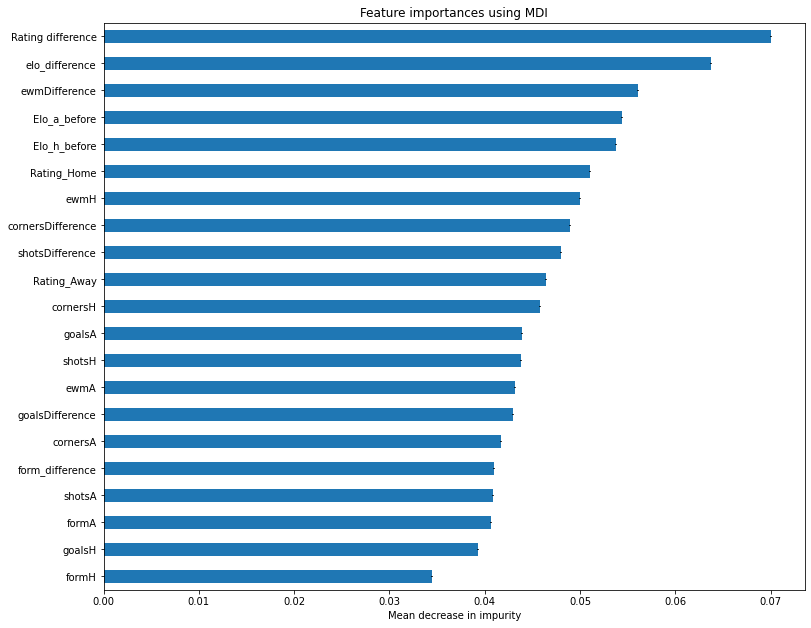

In [34]:

#start_time = time.time()
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
#elapsed_time = time.time() - start_time


#feature_names = [f"feature {i}" for i in range(X.shape[1])]


forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values()
fig, ax = plt.subplots()
fig.tight_layout(pad=-15, w_pad=0.5, h_pad=-2)

forest_importances.plot.barh(ax=ax, yerr=std)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
print(rf_model.score(X_test, y_test))
